Import libraries

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


Load cleaned dataset

In [3]:
df = pd.read_csv("../data/cleaned/openfoodfacts_cleaned.csv")
df.head()


,product_name,brands,categories,countries,ingredients_text,nutriments,scraped_at
0,Sidi Ali,maroc.,"Beverages and beverages preparations,Beverages...",Morocco,OBD1 999 999 1112606 266963207 mb,"{'carbohydrates': 42, 'carbohydrates_100g': 4....",2025-12-02 20:58:12
1,perly,perly,"Dairies,Fermented foods,Fermented milk product...","Morocco,United States","milk cream, cream, sugar, banana, bacteria","{'calcium': 0.25, 'calcium_100g': 0.25, 'calci...",2025-12-02 20:58:12
2,Sidi Ali,Sidi Ali,"Beverages and beverages preparations,Beverages...",Morocco,"Sodium, Calcium, Magnésium, Potassium, Bicarbo...","{'chloride': 0.014, 'chloride_100g': 0.014, 'c...",2025-12-02 20:58:12
3,Eau minérale naturelle,"Les Eaux Minérales d'oulmès,Sidi Ali","Beverages and beverages preparations,Beverages...",Morocco,100% mineral water,{'fruits-vegetables-legumes-estimate-from-ingr...,2025-12-02 20:58:12
4,اكوافينا,AQUAFINA,"Boissons et préparations de boissons,Boissons,...",المغرب,ouverture et avant le : Voir bouteille. après ...,"{'alcohol': 0, 'alcohol_100g': 0, 'alcohol_ser...",2025-12-02 20:58:12


Convert nutriments string → dict

In [4]:
df['nutriments'] = df['nutriments'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) else {}
)


Extract numeric nutrient fields

In [5]:
nutriment_cols = ['energy-kcal_100g', 'sugars_100g', 'fat_100g', 'proteins_100g']

for col in nutriment_cols:
    df[col] = df['nutriments'].apply(lambda d: d.get(col, None))

df[nutriment_cols].head()


,energy-kcal_100g,sugars_100g,fat_100g,proteins_100g
0,0.0,1.4,0.0,0.0
1,97.0,NaN,3.0,8.0
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0


Handle missing numeric values

In [6]:
df_num = df[nutriment_cols].fillna(0)
df_num.head()


,energy-kcal_100g,sugars_100g,fat_100g,proteins_100g
0,0.0,1.4,0.0,0.0
1,97.0,0.0,3.0,8.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


Normalize data

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(df_num)


Train K-Means model

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)


Analyze each cluster

In [9]:
df.groupby('cluster')[nutriment_cols].mean()


,energy-kcal_100g,sugars_100g,fat_100g,proteins_100g
cluster,,,,
0,449.557458,24.944469,21.248885,10.450248
1,152.329012,4.715123,4.944069,5.666240
2,685.742529,2.052813,70.566037,3.252442


In [14]:

health_cols = ['energy-kcal_100g', 'sugars_100g', 'fat_100g', 'proteins_100g']

cluster_means = df.groupby('cluster')[health_cols].mean()
weights = {
    'energy_100g': -0.4,
    'sugars_100g': -0.3,
    'fat_100g':   -0.2,
    'fiber_100g': +0.2,
    'proteins_100g': +0.3
}

def compute_health_score(row):
    score = 0
    for col, w in weights.items():
        if col in row:
            score += row[col] * w
    return score

cluster_means['health_score'] = cluster_means.apply(compute_health_score, axis=1)

cluster_means['health_label'] = cluster_means['health_score'].apply(
    lambda x: 'Healthy' if x > 0 else ('Medium' if x > -50 else 'Unhealthy')
)

cluster_means


,energy-kcal_100g,sugars_100g,fat_100g,proteins_100g,health_score,health_label
cluster,,,,,,
0,449.557458,24.944469,21.248885,10.450248,-8.598043,Medium
1,152.329012,4.715123,4.944069,5.666240,-0.703479,Medium
2,685.742529,2.052813,70.566037,3.252442,-13.753319,Medium


Visualization

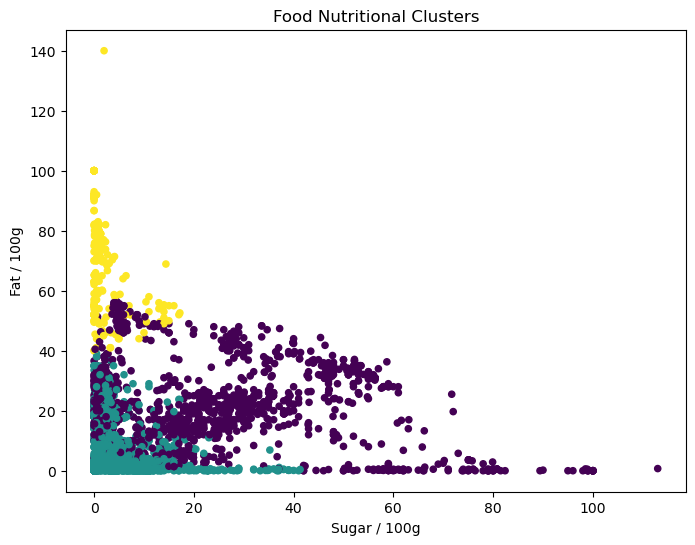

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(df['sugars_100g'], df['fat_100g'], c=df['cluster'], s=20)
plt.xlabel("Sugar / 100g")
plt.ylabel("Fat / 100g")
plt.title("Food Nutritional Clusters")
plt.show()
